# Quantum Convolutional Neural Networks (QCNN) for Audio Spectrogram Classification
- A Hybrid Approach to Quantum Machine Learning

## Import Libraries
This cell imports the necessary libraries:
- **NumPy, Matplotlib**: For numerical operations and visualization.
- **Librosa**: For audio processing and spectrogram generation.
- **PennyLane**: For quantum machine learning and simulation.
- **Autograd**: For automatic differentiation.

In [10]:

# ============================
# 1. Import Necessary Libraries
# ============================

import os
import glob
import shutil
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from tqdm import tqdm  # For progress bars during generation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf



In [ ]:
# ============================
# 2. Define Constants and Functions for Audio Generation
# ============================

# Define constants
DATASET_PATH = "generated_songs"  # Root directory for generated songs
GENRES = ["indian_classical", "western_pop"]  # List of genres
NUM_SAMPLES_PER_GENRE = 100  # Number of samples to generate per genre
SAMPLING_RATE = 22050  # Sampling rate


## Spectrogram Generation
This function generates and visualizes the spectrogram for a given audio files.

In [12]:
# ============================
# 3. Define Functions for Audio Generation
# ============================

def generate_indian_classical_song(sample_num):
    """
    Generates a more complex Indian Classical song simulation.
    """
    duration = 5  # seconds
    t = np.linspace(0, duration, int(SAMPLING_RATE * duration), False)
    frequencies = [220, 330, 440]  # A3, E4, A4 notes
    audio = sum(0.3 * np.sin(2 * np.pi * f * t) for f in frequencies)
    # Add vibrato
    vibrato = 0.05 * np.sin(2 * np.pi * 5 * t)  # 5 Hz vibrato
    audio *= (1 + vibrato)
    # Add background noise
    audio += 0.02 * np.random.randn(len(t))
    return audio

def generate_western_pop_song(sample_num):
    """
    Generates a more complex Western Pop song simulation.
    """
    duration = 5  # seconds
    t = np.linspace(0, duration, int(SAMPLING_RATE * duration), False)
    frequencies = [554.37, 659.25, 880.00]  # C#5, E5, A5 notes
    audio = sum(0.3 * np.sin(2 * np.pi * f * t) for f in frequencies)
    # Apply reverb effect (simulated by simple delay)
    delay_samples = int(0.2 * SAMPLING_RATE)  # 200ms delay
    audio_reverb = np.pad(audio, (delay_samples, 0), mode='constant')[:len(audio)]
    audio += 0.2 * audio_reverb
    # Add background noise
    audio += 0.02 * np.random.randn(len(t))
    return audio

def normalize_audio(audio_data):
    """
    Normalize audio data to int16 format.
    """
    max_val = np.max(np.abs(audio_data))
    if max_val == 0:
        return np.zeros_like(audio_data, dtype=np.int16)
    audio_normalized = audio_data / max_val  # Normalize to [-1, 1]
    audio_int16 = np.int16(audio_normalized * 32767)  # Convert to int16
    return audio_int16

def save_audio(file_path, audio_data, sampling_rate):
    """
    Save audio data to a .wav file.
    """
    try:
        sf.write(file_path, audio_data, sampling_rate)
    except Exception as e:
        print(f"Failed to save {file_path}: {e}")

def plot_spectrogram(audio_path, output_dir='spectrograms', save_plot=True):
    """
    Generates and saves a spectrogram for the given audio file.
    """
    try:
        # Ensure the output directory exists
        if save_plot:
            os.makedirs(output_dir, exist_ok=True)
        
        # Load the audio file
        y, sr = librosa.load(audio_path, sr=None)
        
        # Generate the spectrogram
        D = librosa.stft(y)
        S_db = librosa.amplitude_to_db(abs(D), ref=np.max)
        
        # Plot the spectrogram
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Spectrogram for {os.path.basename(audio_path)}')
        plt.tight_layout()
        
        if save_plot:
            # Save the plot
            base_name = os.path.splitext(os.path.basename(audio_path))[0]
            output_path = os.path.join(output_dir, f"{base_name}_spectrogram.png")
            plt.savefig(output_path)
            plt.close()
            print(f"Spectrogram saved to {output_path}")
        else:
            # Display the plot
            plt.show()
            
    except Exception as e:
        print(f"Error processing file {audio_path}: {e}")

In [13]:
def augment_audio_with_noise(file_path, noise_factor=0.005):
    """
    Augments the audio by adding Gaussian noise.
    Returns a list containing the augmented file path.
    """
    try:
        y, sr = librosa.load(file_path, sr=None)
        noise = np.random.randn(len(y))
        y_noise = y + noise_factor * noise

        # Ensure the augmented audio is still in the valid range
        y_noise = y_noise.astype(type(y[0]))

        # Save the augmented audio
        augmented_file = file_path.replace('.wav', '_noise.wav')
        sf.write(augmented_file, y_noise, sr)
        return [augmented_file]
    except Exception as e:
        print(f"Error augmenting file {file_path}: {e}")
        return []

def augment_audio_with_various(file_path):
    """
    Apply multiple augmentation techniques to the audio file.
    """
    augmented_files = []
    try:
        y, sr = librosa.load(file_path, sr=None)
        
        # Add Noise
        y_noise = y + 0.002 * np.random.randn(len(y))  # Reduced noise_factor
        noise_file = file_path.replace('.wav', '_noise.wav')
        sf.write(noise_file, y_noise, sr)
        augmented_files.append(noise_file)
        
        # Time Stretch
        y_stretch = librosa.effects.time_stretch(y, rate=1.05)  # Less aggressive stretching
        stretch_file = file_path.replace('.wav', '_stretch.wav')
        sf.write(stretch_file, y_stretch, sr)
        augmented_files.append(stretch_file)
        
        # Pitch Shift
        y_pitch = librosa.effects.pitch_shift(y, sr=sr, n_steps=2)  # Smaller pitch shift
        pitch_file = file_path.replace('.wav', '_pitch.wav')
        sf.write(pitch_file, y_pitch, sr)
        augmented_files.append(pitch_file)
        
    except Exception as e:
        print(f"Error augmenting file {file_path}: {e}")
    
    return augmented_files

from skimage.transform import resize


def generate_multiple_samples():
    """
    Generate and save multiple audio samples for each genre.
    Each genre's samples are saved in their respective subdirectories within DATASET_PATH.
    """
    # Clean up the existing dataset directory if it exists
    if os.path.exists(DATASET_PATH):
        try:
            shutil.rmtree(DATASET_PATH)
            print(f"Removed existing directory: {DATASET_PATH}")
        except Exception as e:
            print(f"Error removing directory {DATASET_PATH}: {e}")
            return
    
    # Ensure the root dataset directory exists
    os.makedirs(DATASET_PATH, exist_ok=True)
    print(f"Dataset directory set to: {DATASET_PATH}")
    
    # Create subdirectories for each genre
    genre_paths = {}
    for genre in GENRES:
        genre_dir = os.path.join(DATASET_PATH, genre)
        os.makedirs(genre_dir, exist_ok=True)
        genre_paths[genre] = genre_dir
        print(f"Ensured existence of genre directory: {genre_dir}")
    
    # Generate and save samples for each genre
    for genre in GENRES:
        print(f"\nGenerating samples for genre: {genre}")
        for sample_num in tqdm(range(1, NUM_SAMPLES_PER_GENRE + 1), desc=f"Generating {genre} samples"):
            if genre == "indian_classical":
                audio_data = generate_indian_classical_song(sample_num)
            elif genre == "western_pop":
                audio_data = generate_western_pop_song(sample_num)
            else:
                print(f"Unknown genre '{genre}'. Skipping sample generation.")
                continue  # Skip unknown genres
            
            # Normalize audio
            audio_normalized = normalize_audio(audio_data)
            
            # Define filename and full path
            filename = f"{genre}_sample_{sample_num}.wav"
            file_path = os.path.join(genre_paths[genre], filename)
            
            # Save audio file
            save_audio(file_path, audio_normalized, SAMPLING_RATE)
            # Optionally, plot spectrogram
            plot_spectrogram(file_path)
    
    print("\nAll samples generated and saved successfully.")

# Execute the audio generation
generate_multiple_samples()

Removed existing directory: generated_songs
Dataset directory set to: generated_songs
Ensured existence of genre directory: generated_songs/indian_classical
Ensured existence of genre directory: generated_songs/western_pop

Generating samples for genre: indian_classical


Generating indian_classical samples:  10%|█         | 1/10 [00:00<00:01,  5.62it/s]

Spectrogram saved to spectrograms/indian_classical_sample_1_spectrogram.png


Generating indian_classical samples:  20%|██        | 2/10 [00:00<00:01,  6.11it/s]

Spectrogram saved to spectrograms/indian_classical_sample_2_spectrogram.png


Generating indian_classical samples:  30%|███       | 3/10 [00:00<00:01,  6.25it/s]

Spectrogram saved to spectrograms/indian_classical_sample_3_spectrogram.png


Generating indian_classical samples:  40%|████      | 4/10 [00:00<00:00,  6.35it/s]

Spectrogram saved to spectrograms/indian_classical_sample_4_spectrogram.png


Generating indian_classical samples:  50%|█████     | 5/10 [00:00<00:00,  6.22it/s]

Spectrogram saved to spectrograms/indian_classical_sample_5_spectrogram.png


Generating indian_classical samples:  60%|██████    | 6/10 [00:00<00:00,  5.89it/s]

Spectrogram saved to spectrograms/indian_classical_sample_6_spectrogram.png


Generating indian_classical samples:  70%|███████   | 7/10 [00:01<00:00,  6.15it/s]

Spectrogram saved to spectrograms/indian_classical_sample_7_spectrogram.png


Generating indian_classical samples:  80%|████████  | 8/10 [00:01<00:00,  6.29it/s]

Spectrogram saved to spectrograms/indian_classical_sample_8_spectrogram.png


Generating indian_classical samples:  90%|█████████ | 9/10 [00:01<00:00,  6.44it/s]

Spectrogram saved to spectrograms/indian_classical_sample_9_spectrogram.png


Generating indian_classical samples: 100%|██████████| 10/10 [00:01<00:00,  6.30it/s]


Spectrogram saved to spectrograms/indian_classical_sample_10_spectrogram.png

Generating samples for genre: western_pop


Generating western_pop samples:  10%|█         | 1/10 [00:00<00:01,  6.97it/s]

Spectrogram saved to spectrograms/western_pop_sample_1_spectrogram.png


Generating western_pop samples:  20%|██        | 2/10 [00:00<00:01,  6.90it/s]

Spectrogram saved to spectrograms/western_pop_sample_2_spectrogram.png


Generating western_pop samples:  30%|███       | 3/10 [00:00<00:01,  6.86it/s]

Spectrogram saved to spectrograms/western_pop_sample_3_spectrogram.png


Generating western_pop samples:  40%|████      | 4/10 [00:00<00:00,  6.67it/s]

Spectrogram saved to spectrograms/western_pop_sample_4_spectrogram.png


Generating western_pop samples:  50%|█████     | 5/10 [00:00<00:00,  6.68it/s]

Spectrogram saved to spectrograms/western_pop_sample_5_spectrogram.png


Generating western_pop samples:  60%|██████    | 6/10 [00:00<00:00,  6.76it/s]

Spectrogram saved to spectrograms/western_pop_sample_6_spectrogram.png


Generating western_pop samples:  70%|███████   | 7/10 [00:01<00:00,  6.84it/s]

Spectrogram saved to spectrograms/western_pop_sample_7_spectrogram.png


Generating western_pop samples:  80%|████████  | 8/10 [00:01<00:00,  6.85it/s]

Spectrogram saved to spectrograms/western_pop_sample_8_spectrogram.png


Generating western_pop samples: 100%|██████████| 10/10 [00:01<00:00,  6.53it/s]

Spectrogram saved to spectrograms/western_pop_sample_9_spectrogram.png
Spectrogram saved to spectrograms/western_pop_sample_10_spectrogram.png

All samples generated and saved successfully.


## Data Loading and Processing
This function processes audio files into normalized spectrograms for training/testing.
- **Inputs**:
  - `audio_files`: List of audio file paths.
  - `labels`: Corresponding binary labels.
  - `num_features`: Feature size for quantum embedding.
  - `test_split`: Proportion of test data.
- **Outputs**: Train/test data splits: `X_train, X_test, Y_train, Y_test`.


In [14]:
# List of genres and corresponding labels
genre_labels = {"indian_classical": 0, "western_pop": 1}  # 0: Indian Classical, 1: Western Pop

audio_files = []
labels = []

# Iterate through each genre directory and collect audio files and labels
for genre, label in genre_labels.items():
    genre_path = os.path.join(DATASET_PATH, genre)
    if not os.path.isdir(genre_path):
        print(f"Genre directory {genre_path} does not exist. Skipping.")
        continue
    # Find all WAV files in the genre directory
    genre_audio_files = glob.glob(os.path.join(genre_path, '*.wav'))
    audio_files.extend(genre_audio_files)
    labels.extend([label] * len(genre_audio_files))
    print(f"Found {len(genre_audio_files)} audio files for genre '{genre}'.")

print(f"\nTotal audio files collected: {len(audio_files)}")
print(f"Total labels collected: {len(labels)}")

# **Verify Label Alignment:**
for i in range(min(10, len(audio_files))):
    print(f"File: {audio_files[i]}, Label: {labels[i]}")

Found 10 audio files for genre 'indian_classical'.
Found 10 audio files for genre 'western_pop'.

Total audio files collected: 20
Total labels collected: 20
File: generated_songs/indian_classical/indian_classical_sample_1.wav, Label: 0
File: generated_songs/indian_classical/indian_classical_sample_3.wav, Label: 0
File: generated_songs/indian_classical/indian_classical_sample_2.wav, Label: 0
File: generated_songs/indian_classical/indian_classical_sample_10.wav, Label: 0
File: generated_songs/indian_classical/indian_classical_sample_6.wav, Label: 0
File: generated_songs/indian_classical/indian_classical_sample_7.wav, Label: 0
File: generated_songs/indian_classical/indian_classical_sample_5.wav, Label: 0
File: generated_songs/indian_classical/indian_classical_sample_4.wav, Label: 0
File: generated_songs/indian_classical/indian_classical_sample_9.wav, Label: 0
File: generated_songs/indian_classical/indian_classical_sample_8.wav, Label: 0


## Load and Display Spectrograms

In [15]:
# ============================
# 3. Load and Process Audio Files for CNN
# ============================
from skimage.transform import resize

def data_load_and_process_separate_augmentation(audio_files, labels, num_mfcc=40, img_height=40, img_width=128, test_split=0.2):
    """
    Preprocess audio files with augmentation applied only to the training set.
    """
    X = []
    Y = []
    for idx, file in enumerate(audio_files):
        try:
            y, sr = librosa.load(file, sr=None)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)
            mfcc_scaled = librosa.util.normalize(mfcc)
            mfcc_resized = resize(mfcc_scaled, (img_height, img_width), mode='constant')
            
            # Ensure the shape is (img_height, img_width, 1)
            if len(mfcc_resized.shape) == 2:
                mfcc_resized = mfcc_resized[..., np.newaxis]
            elif len(mfcc_resized.shape) == 3:
                pass  # Already has channel dimension
            else:
                print(f"Unexpected shape {mfcc_resized.shape} for file {file}")
                continue
            
            X.append(mfcc_resized)
            Y.append(labels[idx])
        except Exception as e:
            print(f"Error processing file {file}: {e}")
            continue
    
    X = np.array(X)
    Y = np.array(Y)
    
    # Train-test split with stratification
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=test_split, stratify=Y, random_state=42
    )
    
    # Augment training data
    augmented_X = []
    augmented_Y = []
    for i in range(len(X_train)):
        file_path = audio_files[i]
        augmented_files = augment_audio_with_various(file_path)
        for aug_file in augmented_files:
            try:
                y_aug, sr_aug = librosa.load(aug_file, sr=None)
                mfcc_aug = librosa.feature.mfcc(y=y_aug, sr=sr_aug, n_mfcc=num_mfcc)
                mfcc_aug_scaled = librosa.util.normalize(mfcc_aug)
                mfcc_aug_resized = resize(mfcc_aug_scaled, (img_height, img_width), mode='constant')
                
                # Ensure the shape is (img_height, img_width, 1)
                if len(mfcc_aug_resized.shape) == 2:
                    mfcc_aug_resized = mfcc_aug_resized[..., np.newaxis]
                elif len(mfcc_aug_resized.shape) == 3:
                    pass
                else:
                    print(f"Unexpected shape {mfcc_aug_resized.shape} for file {aug_file}")
                    continue
                
                augmented_X.append(mfcc_aug_resized)
                augmented_Y.append(Y_train[i])
            except Exception as e:
                print(f"Error processing augmented file {aug_file}: {e}")
                continue
    
    if augmented_X:
        X_train = np.concatenate((X_train, np.array(augmented_X)), axis=0)
        Y_train = np.concatenate((Y_train, np.array(augmented_Y)), axis=0)
    
    # Shuffle training data
    shuffle_idx = np.random.permutation(len(X_train))
    X_train = X_train[shuffle_idx]
    Y_train = Y_train[shuffle_idx]
    
    return X_train, X_test, Y_train, Y_test

# Preprocess data
try:
    X_train, X_test, Y_train, Y_test = data_load_and_process_separate_augmentation(
        audio_files, labels, num_mfcc=40, img_height=40, img_width=128, test_split=0.2
    )
    print(f"Training Data Shape: {X_train.shape}, Testing Data Shape: {X_test.shape}")
except Exception as e:
    print(f"Pipeline failed: {e}")


# ============================
# 7. Convert Labels to One-Hot Encoding
# ============================

if 'Y_train' in locals() and 'Y_test' in locals():
    num_classes = len(genre_labels)
    Y_train_onehot = tf.keras.utils.to_categorical(Y_train, num_classes=num_classes)
    Y_test_onehot = tf.keras.utils.to_categorical(Y_test, num_classes=num_classes)
    print("Labels converted to one-hot encoding successfully.")
else:
    print("Pipeline failed: cannot access 'Y_train' and 'Y_test' because they are not defined.")


Training Data Shape: (64, 40, 128, 1), Testing Data Shape: (4, 40, 128, 1)
Labels converted to one-hot encoding successfully.


## CNN-based classifier for the spectogram data and find the accuracy results

### Augment_audio Method
- **Purpose**: To artificially expand the dataset through data augmentation, creating variations of the same audio file (e.g., pitch-shifted, time-stretched).
- **Why for CNN**:
  - CNNs benefit from diverse training data to prevent overfitting.
  - By augmenting the spectrogram inputs, CNNs can learn generalized features.
- **Usage**: Augment audio files before converting them to spectrograms and feeding them into the CNN.

## Build CNN

In [16]:
# ============================
# 4. Define the CNN Model
# ============================

def build_simpler_cnn(input_shape):
    """
    Builds a simpler CNN model to prevent overfitting.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation='softmax')  # Binary classification
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [17]:
# ============================
# 5. Collect Audio Files and Assign Labels
# ============================

# List of genres and corresponding labels
genre_labels = {"indian_classical": 0, "western_pop": 1}  # 0: Indian Classical, 1: Western Pop

audio_files = []
labels = []

# Iterate through each genre directory and collect audio files and labels
for genre, label in genre_labels.items():
    genre_path = os.path.join(DATASET_PATH, genre)
    if not os.path.isdir(genre_path):
        print(f"Genre directory {genre_path} does not exist. Skipping.")
        continue
    # Find all WAV files in the genre directory
    genre_audio_files = glob.glob(os.path.join(genre_path, '*.wav'))
    audio_files.extend(genre_audio_files)
    labels.extend([label] * len(genre_audio_files))
    print(f"Found {len(genre_audio_files)} audio files for genre '{genre}'.")

print(f"\nTotal audio files collected: {len(audio_files)}")
print(f"Total labels collected: {len(labels)}")

# **Verify Label Alignment:**
for i in range(min(10, len(audio_files))):
    print(f"File: {audio_files[i]}, Label: {labels[i]}")

Found 40 audio files for genre 'indian_classical'.
Found 28 audio files for genre 'western_pop'.

Total audio files collected: 68
Total labels collected: 68
File: generated_songs/indian_classical/indian_classical_sample_4_noise.wav, Label: 0
File: generated_songs/indian_classical/indian_classical_sample_8_pitch.wav, Label: 0
File: generated_songs/indian_classical/indian_classical_sample_9_noise.wav, Label: 0
File: generated_songs/indian_classical/indian_classical_sample_5_pitch.wav, Label: 0
File: generated_songs/indian_classical/indian_classical_sample_6_stretch.wav, Label: 0
File: generated_songs/indian_classical/indian_classical_sample_10_noise.wav, Label: 0
File: generated_songs/indian_classical/indian_classical_sample_3_stretch.wav, Label: 0
File: generated_songs/indian_classical/indian_classical_sample_2_noise.wav, Label: 0
File: generated_songs/indian_classical/indian_classical_sample_3_pitch.wav, Label: 0
File: generated_songs/indian_classical/indian_classical_sample_5_noise.wa

Pipeline failed: name 'data_load_and_process' is not defined
Epoch 1/50
4/4 [==============================] - 0s 37ms/step - loss: 0.8188 - accuracy: 0.4706 - val_loss: 0.6855 - val_accuracy: 0.5385
Epoch 2/50
4/4 [==============================] - 0s 17ms/step - loss: 0.7231 - accuracy: 0.5098 - val_loss: 0.6845 - val_accuracy: 0.5385
Epoch 3/50
4/4 [==============================] - 0s 14ms/step - loss: 0.7276 - accuracy: 0.3922 - val_loss: 0.6905 - val_accuracy: 0.5385
Epoch 4/50
4/4 [==============================] - 0s 14ms/step - loss: 0.6956 - accuracy: 0.4902 - val_loss: 0.6927 - val_accuracy: 0.5385
Epoch 5/50


/opt/anaconda3/envs/conda_venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 13ms/step - loss: 0.6930 - accuracy: 0.4706 - val_loss: 0.6932 - val_accuracy: 0.4615
Epoch 6/50
4/4 [==============================] - 0s 12ms/step - loss: 0.6949 - accuracy: 0.4902 - val_loss: 0.6930 - val_accuracy: 0.5385
Epoch 7/50
4/4 [==============================] - 0s 13ms/step - loss: 0.6868 - accuracy: 0.5294 - val_loss: 0.6932 - val_accuracy: 0.4615
Final CNN Accuracy: 50.00%
1/1 [==============================] - 0s 32ms/step
Final CNN Accuracy using sklearn: 50.00%


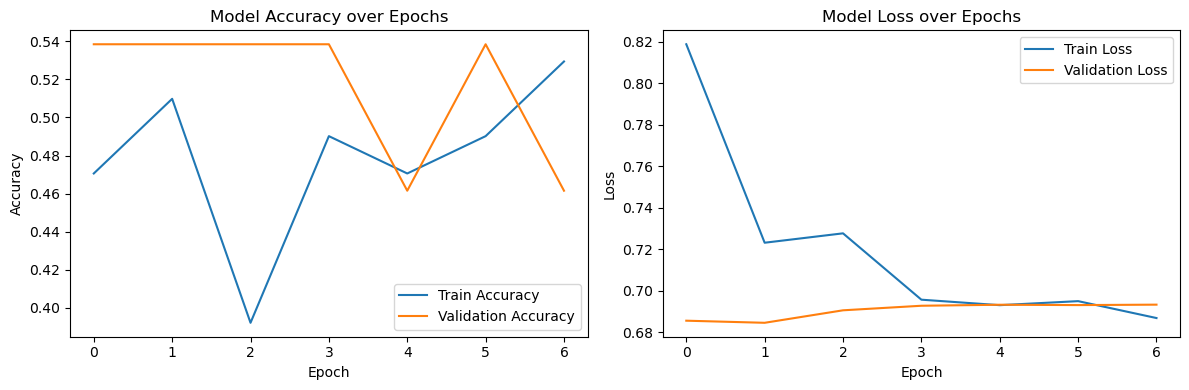

Confusion Matrix:
[[0 2]
 [0 2]]

Classification Report:
                  precision    recall  f1-score   support

indian_classical       0.00      0.00      0.00         2
     western_pop       0.50      1.00      0.67         2

        accuracy                           0.50         4
       macro avg       0.25      0.50      0.33         4
    weighted avg       0.25      0.50      0.33         4



/opt/anaconda3/envs/conda_venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/conda_venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/conda_venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [18]:
# ============================
# 6. Preprocess Data
# ============================

# Preprocess data
try:
    X_train, X_test, Y_train, Y_test = data_load_and_process(audio_files, labels, num_mfcc=40, img_height=40, img_width=128, test_split=0.2)
    print(f"Training Data Shape: {X_train.shape}, Testing Data Shape: {X_test.shape}")
except Exception as e:
    print(f"Pipeline failed: {e}")

# ============================
# 7. Convert Labels to One-Hot Encoding
# ============================

num_classes = len(genre_labels)
Y_train_onehot = tf.keras.utils.to_categorical(Y_train, num_classes=num_classes)
Y_test_onehot = tf.keras.utils.to_categorical(Y_test, num_classes=num_classes)

# ============================
# 8. Build and Compile the CNN Model
# ============================
cnn_model = build_simpler_cnn(X_train.shape[1:])
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# ============================
# 9. Define Callbacks
# ============================

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_cnn_model.h5', monitor='val_loss', save_best_only=True)

# ============================
# 10. Train the CNN Model
# ============================

history = cnn_model.fit(
    X_train, Y_train_onehot,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# ============================
# 11. Evaluate the CNN Model
# ============================

# Evaluate the CNN model
loss, accuracy = cnn_model.evaluate(X_test, Y_test_onehot, verbose=0)
print(f"Final CNN Accuracy: {accuracy * 100:.2f}%")

# Predictions and accuracy
Y_pred = np.argmax(cnn_model.predict(X_test), axis=1)
Y_true = np.argmax(Y_test_onehot, axis=1)
final_accuracy = accuracy_score(Y_true, Y_pred)
print(f"Final CNN Accuracy using sklearn: {final_accuracy * 100:.2f}%")

# ============================
# 12. Plot Training History
# ============================

# Plot Training History
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ============================
# 13. Display Confusion Matrix and Classification Report
# ============================

cm = confusion_matrix(Y_true, Y_pred)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(Y_true, Y_pred, target_names=genre_labels.keys()))

## Data Preprocessing for Quantum Models
Processes audio data into spectrograms, normalizes them, and splits them into training and testing datasets, preparing them for QCNN input

In [19]:
def data_load_and_process(audio_files=None, labels=None, num_features=256, test_split=0.2):
    import numpy as np
    import librosa

    spectrograms = []
    for file in audio_files:
        try:
            y, sr = librosa.load(file, sr=None)
            D = librosa.stft(y)
            S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

            S_flattened = S_db.flatten()
            if len(S_flattened) >= num_features:
                S_resized = S_flattened[:num_features]
            else:
                S_resized = np.pad(S_flattened, (0, num_features - len(S_flattened)), mode='constant')

            S_normalized = S_resized / np.linalg.norm(S_resized)
            spectrograms.append(S_normalized)
        except Exception as e:
            print(f"Error processing file {file}: {e}")
            continue

    X = np.array(spectrograms)
    if len(labels) == 2:  # If binary labels are provided
        labels = np.tile(labels, len(X) // len(labels) + 1)[:len(X)]

    Y = np.array(labels)
    split_index = int(len(X) * (1 - test_split))
    X_train, X_test = X[:split_index], X[split_index:]
    Y_train, Y_test = Y[:split_index], Y[split_index:]

    return X_train, X_test, Y_train, Y_test


## Quantum Circuit Components
Defines modular building blocks for the Quantum Convolutional Neural Network (QCNN), including:
- **Unitary gates**: E.g., `U_TTN`.
- **Convolutional layers**: Apply quantum operations.
- **Pooling layers**: Reduce quantum states.

In [20]:
# Quantum Circuit Components
def U_TTN(params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])

def U_5(params, wires):  # 10 params
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[0])
    qml.RZ(params[3], wires=wires[1])
    qml.CRZ(params[4], wires=[wires[1], wires[0]])
    qml.CRZ(params[5], wires=[wires[0], wires[1]])
    qml.RX(params[6], wires=wires[0])
    qml.RX(params[7], wires=wires[1])
    qml.RZ(params[8], wires=wires[0])
    qml.RZ(params[9], wires=wires[1])


def U_6(params, wires):  # 10 params
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[0])
    qml.RZ(params[3], wires=wires[1])
    qml.CRX(params[4], wires=[wires[1], wires[0]])
    qml.CRX(params[5], wires=[wires[0], wires[1]])
    qml.RX(params[6], wires=wires[0])
    qml.RX(params[7], wires=wires[1])
    qml.RZ(params[8], wires=wires[0])
    qml.RZ(params[9], wires=wires[1])


def U_9(params, wires):  # 2 params
    qml.Hadamard(wires=wires[0])
    qml.Hadamard(wires=wires[1])
    qml.CZ(wires=[wires[0], wires[1]])
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])


def U_13(params, wires):  # 6 params
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CRZ(params[2], wires=[wires[1], wires[0]])
    qml.RY(params[3], wires=wires[0])
    qml.RY(params[4], wires=wires[1])
    qml.CRZ(params[5], wires=[wires[0], wires[1]])


def U_14(params, wires):  # 6 params
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CRX(params[2], wires=[wires[1], wires[0]])
    qml.RY(params[3], wires=wires[0])
    qml.RY(params[4], wires=wires[1])
    qml.CRX(params[5], wires=[wires[0], wires[1]])


def U_15(params, wires):  # 4 params
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])


def U_SO4(params, wires):  # 6 params
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[4], wires=wires[0])
    qml.RY(params[5], wires=wires[1])


def U_SU4(params, wires): # 15 params
    qml.U3(params[0], params[1], params[2], wires=wires[0])
    qml.U3(params[3], params[4], params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[6], wires=wires[0])
    qml.RZ(params[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(params[9], params[10], params[11], wires=wires[0])
    qml.U3(params[12], params[13], params[14], wires=wires[1])

# Quantum Circuits for Convolutional layers
def conv_layer1(U, params):
    U(params, wires=[0, 7])
    for i in range(0, 8, 2):
        U(params, wires=[i, i + 1])
    for i in range(1, 7, 2):
        U(params, wires=[i, i + 1])

def conv_layer2(U, params):
    U(params, wires=[0, 6])
    U(params, wires=[0, 2])
    U(params, wires=[4, 6])
    U(params, wires=[2, 4])

def conv_layer3(U, params):
    U(params, wires=[0,4])

## Define Pooling Strategies
Pooling layers reduce the size of the quantum data, similar to classical pooling in CNNs.

In [21]:
# Pooling layers

def Pooling_ansatz1(params, wires):
    qml.CRZ(params[0], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRX(params[1], wires=[wires[0], wires[1]])

def pooling_layer1(V, params):
    for i in range(0, 8, 2):
        V(params, wires=[i + 1, i])

def pooling_layer2(V, params):
    V(params, wires=[2,0])
    V(params, wires=[6,4])

def pooling_layer3(V, params):
    V(params, wires=[0,4])

## QCNN Structure
Defines the full QCNN architecture, including convolutional and pooling layers.

In [22]:
def QCNN_structure(U, params, U_params):
    param1 = params[0:U_params]
    param2 = params[U_params: 2 * U_params]
    param3 = params[2 * U_params: 3 * U_params]
    param4 = params[3 * U_params: 3 * U_params + 2]
    param5 = params[3 * U_params + 2: 3 * U_params + 4]
    param6 = params[3 * U_params + 4: 3 * U_params + 6]

    conv_layer1(U, param1)
    pooling_layer1(Pooling_ansatz1, param4)
    conv_layer2(U, param2)
    pooling_layer2(Pooling_ansatz1, param5)
    conv_layer3(U, param3)
    pooling_layer3(Pooling_ansatz1, param6)

def QCNN_structure_without_pooling(U, params, U_params):
    param1 = params[0:U_params]
    param2 = params[U_params: 2 * U_params]
    param3 = params[2 * U_params: 3 * U_params]

    conv_layer1(U, param1)
    conv_layer2(U, param2)
    conv_layer3(U, param3)

def QCNN_1D_circuit(U, params, U_params):
    param1 = params[0: U_params]
    param2 = params[U_params: 2*U_params]
    param3 = params[2*U_params: 3*U_params]

    for i in range(0, 8, 2):
        U(param1, wires=[i, i + 1])
    for i in range(1, 7, 2):
        U(param1, wires=[i, i + 1])

    U(param2, wires=[2,3])
    U(param2, wires=[4,5])
    U(param3, wires=[3,4])

## QCNN Circuit
Implements the QCNN with amplitude embedding and modular structure. The output is based on the cost function:
- **Cross-entropy**: Returns probabilities.
- **Mean-squared error**: Returns expectation value.

## The dev variable initializes a quantum device. In this example "default.qubit" with 8 wires is used.

In [23]:
import pennylane as qml
import pennylane as qml
from pennylane.templates.embeddings import AmplitudeEmbedding

# Define the QCNN quantum node
dev = qml.device('default.qubit', wires = 8)
@qml.qnode(dev)
def QCNN(X, params, U, U_params, cost_fn='cross_entropy'):

    # Data Embedding - Consider Amplitude Embedding
    AmplitudeEmbedding(X, wires=range(8), normalize=True)

    # Quantum Convolutional Neural Network
    if U == 'U_TTN':
        QCNN_structure(U_TTN, params, U_params)
    elif U == 'U_5':
        QCNN_structure(U_5, params, U_params)
    elif U == 'U_6':
        QCNN_structure(U_6, params, U_params)
    elif U == 'U_9':
        QCNN_structure(U_9, params, U_params)
    elif U == 'U_13':
        QCNN_structure(U_13, params, U_params)
    elif U == 'U_14':
        QCNN_structure(U_14, params, U_params)
    elif U == 'U_15':
        QCNN_structure(U_15, params, U_params)
    elif U == 'U_SO4':
        QCNN_structure(U_SO4, params, U_params)
    elif U == 'U_SU4':
        QCNN_structure(U_SU4, params, U_params)
    elif U == 'U_SU4_no_pooling':
        QCNN_structure_without_pooling(U_SU4, params, U_params)
    elif U == 'U_SU4_1D':
        QCNN_1D_circuit(U_SU4, params, U_params)
    elif U == 'U_9_1D':
        QCNN_1D_circuit(U_9, params, U_params)
    else:
        print("Invalid Unitary Ansatze")
        return False

    if cost_fn == 'mse':
        result = qml.expval(qml.PauliZ(4))
    elif cost_fn == 'cross_entropy':
        result = qml.probs(wires=4)
    return result

## QCNN Training
Defines the training loop for QCNN using the Nesterov Momentum Optimizer.
- **Input**: Training data, QCNN parameters.
- **Output**: Loss history, trained parameters.

## This cell contains functions for computing loss, training the circuit, and tracking the loss history.

In [24]:
# Implementation of Quantum circuit training procedure
from pennylane import numpy as pnp
import autograd.numpy as anp

# Define loss functions
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

def cross_entropy(labels, predictions):
    """
    Calculate cross-entropy loss between labels and predictions.

    Args:
        labels (list): True labels.
        predictions (list): Predicted probabilities.

    Returns:
        float: Cross-entropy loss.
    """
    loss = 0
    for l, p in zip(labels, predictions):
        # Ensure index access and valid probabilities
        c_entropy = l * (anp.log(p[0])) + (1 - l) * anp.log(1 - p[1])
        loss += c_entropy
    return -1 * loss

def cost(params, X, Y, U, U_params, cost_fn):
    predictions = [QCNN(x, params, U, U_params, cost_fn) for x in X]
    if cost_fn == 'mse':
        return square_loss(Y, predictions)
    elif cost_fn == 'cross_entropy':
        return cross_entropy(Y, predictions)

def circuit_training(X_train, Y_train, U, U_params, cost_fn):
    params = pnp.random.randn(U_params * 3 + 6, requires_grad=True)
    opt = qml.NesterovMomentumOptimizer(stepsize=0.01)
    loss_history = []

    for _ in range(200):
        batch_index = pnp.random.randint(0, len(X_train), (25,))
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]
        params, cost_val = opt.step_and_cost(lambda v: cost(v, X_batch, Y_batch, U, U_params, cost_fn), params)
        loss_history.append(cost_val)
    return loss_history, params

## QCNN Benchmarking
Runs training and evaluation for different QCNN architectures (unitaries).
- **Input**: List of unitary ansatze and cost functions.
- **Output**: Training loss and accuracy.

In [25]:
def accuracy_test(predictions, labels, cost_fn):
    if cost_fn == 'mse':
        acc = 0
        for l, p in zip(labels, predictions):
            if np.abs(l - p) < 0.5:
                acc = acc + 1
        return acc / len(labels)

    elif cost_fn == 'cross_entropy':
        acc = 0
        for l,p in zip(labels, predictions):
            if p[0] > p[1]:
                P = 0
            else:
                P = 1
            if P == l:
                acc = acc + 1
        return acc / len(labels)

def Benchmarking(Unitaries, U_num_params, cost_fn):
    for i, U in enumerate(Unitaries):
        X_train, X_test, Y_train, Y_test = data_load_and_process(audio_files, labels)
        loss_history, trained_params = circuit_training(X_train, Y_train, U, U_num_params[i], cost_fn)
        predictions = [QCNN(x, trained_params, U, U_num_params[i], cost_fn) for x in X_test]
        accuracy = accuracy_test(predictions, Y_test, cost_fn)
        print(f"Accuracy for {U}: {accuracy}")

## Actual Training
- Run the QCNN circuit with multiple unitary parametrized gates, evaluate the cross-entropy loss, and benchmark their performance on the provided dataset.

In [26]:
def Benchmarking(Unitaries, U_num_params, cost_fn):
    """
    Benchmark the QCNN performance for different unitary ansatze.

    Args:
        Unitaries (list): List of unitary ansatze names.
        U_num_params (list): List of parameter counts corresponding to each unitary.
        cost_fn (str): Loss function to use ('mse' or 'cross_entropy').

    Returns:
        None: Prints loss history and accuracy for each unitary ansatz.
    """
    print("=== QCNN Benchmarking ===")
    for i, U in enumerate(Unitaries):
        print(f"\n--- Benchmarking for Unitary: {U} ---")

        # Load and preprocess the dataset
        X_train, X_test, Y_train, Y_test = data_load_and_process(audio_files, labels)

        # Train the QCNN circuit
        loss_history, trained_params = circuit_training(X_train, Y_train, U, U_num_params[i], cost_fn)

        # Evaluate the model on the test set
        predictions = [QCNN(x, trained_params, U, U_num_params[i], cost_fn) for x in X_test]
        accuracy = accuracy_test(predictions, Y_test, cost_fn)

        # Display results
        print(f"Final Accuracy for {U}: {accuracy * 100:.2f}%")
        print(f"Loss History for {U}: {loss_history[-5:]} (last 5 iterations)")
        print("-" * 50)

# Define parameters for benchmarking
Unitaries = ['U_SU4', 'U_SU4_1D', 'U_SU4_no_pooling', 'U_9_1D']
U_num_params = [15, 15, 15, 2]
cost_fn = 'cross_entropy'

# Run benchmarking
Benchmarking(Unitaries, U_num_params, cost_fn=cost_fn)

=== QCNN Benchmarking ===

--- Benchmarking for Unitary: U_SU4 ---


/opt/anaconda3/envs/conda_venv/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:698: ComplexWarning: Casting complex values to real discards the imaginary part
  onp.add.at(A, idx, x)


Final Accuracy for U_SU4: 0.00%
Loss History for U_SU4: [0.33172906954286135, 0.3182812847535848, 0.3185349892833423, 0.32026193065996317, 0.30923631886188624] (last 5 iterations)
--------------------------------------------------

--- Benchmarking for Unitary: U_SU4_1D ---
Final Accuracy for U_SU4_1D: 0.00%
Loss History for U_SU4_1D: [0.24952500773848946, 0.2550710065015386, 0.24747127928052617, 0.24405425182600415, 0.25622442887407565] (last 5 iterations)
--------------------------------------------------

--- Benchmarking for Unitary: U_SU4_no_pooling ---
Final Accuracy for U_SU4_no_pooling: 0.00%
Loss History for U_SU4_no_pooling: [0.4941726813634798, 0.46734443049155916, 0.45525916878411893, 0.38561962564216634, 0.34519415659772956] (last 5 iterations)
--------------------------------------------------

--- Benchmarking for Unitary: U_9_1D ---
Final Accuracy for U_9_1D: 14.29%
Loss History for U_9_1D: [16.44859988039542, 16.35029396671171, 16.375614747943214, 16.390359182396235, 1